In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

sns.set(font_scale=1.5)

red = '#FF3300'
blue = '#0099CC'
green = '#00CC66'

# Класс `Data`

Класс Data данных обертывает общие переменные Theano и позволяет модели знать о своих входах и выходах. Это позволяет изменять значение наблюдаемой переменной для прогнозирования или переобучения на новые данные. Все переменные этого класса должны быть объявлены в контексте модели и указать имя для них.

Рассмотрим пример

$X\;|\;\theta \sim \mathcal{N}(\theta, 1)$

$\theta \sim \mathcal{N}(0, 10)$

Сгенерируем выборку размера 10 из $\mathcal{N}(30, 1)$.

In [2]:
true_theta = 30
observed_data = sps.norm(loc=true_theta).rvs(size=10)

Зададим *обычную* модель

In [3]:
with pm.Model() as model:
    # априорное распределение параметра
    theta = pm.Normal('theta', 0, 10)
    # распределение данных
    X = pm.Normal('x', mu=theta, sigma=1, observed=observed_data)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 3265.95draws/s]


Теперь предварительно обернем данные в класс `pm.Data`

In [4]:
with pm.Model() as model:
    # объявляем данные
    data = pm.Data('data', observed_data)
    
    # априорное распределение параметра
    theta = pm.Normal('mu', 0, 10)
    # распределение данных
    X = pm.Normal('x', mu=theta, sigma=1, observed=data)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 3262.42draws/s]
The acceptance probability does not match the target. It is 0.8796802243729286, but should be close to 0.8. Try to increase the number of tuning steps.


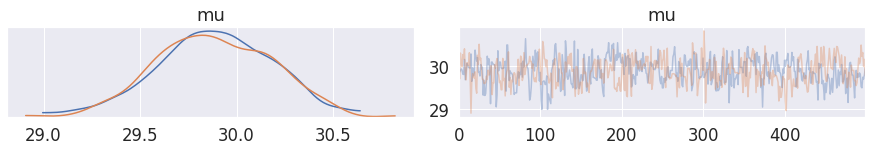

In [5]:
az.plot_trace(trace);

Мы можем получить контейнер данных из модели:

In [6]:
model['data'].get_value()

array([29.65429303, 29.98958722, 30.98953342, 30.43409256, 29.7550387 ,
       29.29249797, 29.66107936, 30.01808116, 30.09184014, 29.378077  ])

Схематическое представление модели:

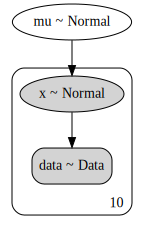

In [7]:
pm.model_to_graphviz(model)

Функции, применимые к контейнеру данных:
* `data_container.get_value` -- возвращает данные из контейнера
* `data_container.set_value` -- кладет новые значения *тех же данных* в контейнер
* `pm.set_data` -- кладет *новые данные* в контейнер

------------------

## Получение предиктивного распределения


Рассмотрим другой пример, все величины одномерные

$Y\;|\;\theta \sim \mathcal{N}(x\theta, 1)$

$\theta \sim \mathcal{N}(0, 1)$

$x$ неслучаен

In [8]:
with pm.Model() as model:
    # объявим данные
    x_data = pm.Data('x_data', np.arange(5))
    y_data = pm.Data('y_data', np.arange(5))
    
    # априорное распределение параметра
    theta = pm.Normal('theta', 0, 1)
    
    # распределение данных
    Y = pm.Normal('Y', mu=x_data*theta, sigma=1, observed=y_data)
    
    trace = pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3150.02draws/s]


Приходят новые данные (тестовые), кладем их в контейнер с данными и семплируем из предиктивного распределения уже для новых данных

In [9]:
x_new = [5, 6, 9]

with model:
    pm.set_data({'x_data': x_new})
    
    y_test = pm.sample_posterior_predictive(trace)

100%|██████████| 6000/6000 [01:05<00:00, 91.24it/s] 


Полученный объект имеет размерность *число семплов* на *размер новых данных*

In [10]:
y_test['Y'].shape

(6000, 3)

Можно посчитать предиктивные средние и дисперсию

In [11]:
y_test['Y'].mean(axis=0), y_test['Y'].std(axis=0)

(array([4.86354426, 5.82531047, 8.73442435]),
 array([1.35038114, 1.48417698, 1.91972974]))

Или же построить само предиктивное распределение

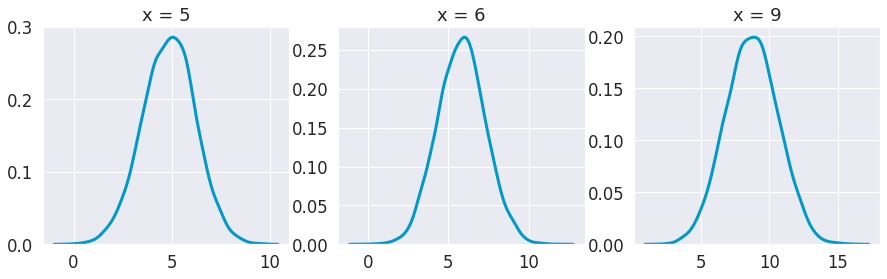

In [12]:
plt.figure(figsize=(15, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(y_test['Y'][:, i], color=blue, lw=3)
    plt.title('x = {}'.format(x_new[i]))